# A few useful functions

This notebook contains code to perform two tasks:

1. **Spatial prediction with `FEEMSmix`**
2. **Analysis of model fits with PCA and `admixture`** (Alexander _et al_ 2009)

In [168]:
# base
import numpy as np
from importlib import resources
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm
from sklearn.impute import SimpleImputer
from statsmodels.stats.multitest import fdrcorrection
from pandas_plink import read_plink
import statsmodels.api as sm
from copy import copy

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# feems
import sys
sys.path.append('../../')
from feems.utils import prepare_graph_inputs, cov_to_dist, pariwise_PCA_distances, pairwise_admixture_distances
from feems.objective import comp_mats
from feems.viz import draw_FEEMSmix_fit, plot_FEEMSmix_result, project_coords
from feems import SpatialGraph, Objective, Viz

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

## Spatial prediction

Using data from the North American grey wolves in [Schweizer _et al_ 2016](https://onlinelibrary.wiley.com/doi/full/10.1111/mec.13364?casa_token=idW0quVPOU0AAAAA%3Ao_ll85b8rDbnW3GtgVeeBUB4oDepm9hQW3Y445HI84LC5itXsiH9dGO-QYGPMsuz0b_7eNkRp8Mf6tlW), I will demonstrate how one can use `FEEMSmix` to geo-locate a sample with (un)known coordinates. Let us go through the steps of creating and assigning the graph as usual. 

In [2]:
data_path = str(resources.files('feems') / 'data')

# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

# setup graph
coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_50.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)


Mapping files: 100%|██████████| 3/3 [00:00<00:00, 95.36it/s]


n_samples=111, n_snps=17729


Initializing graph...
Computing graph attributes...
Assigning samples to nodes...done.


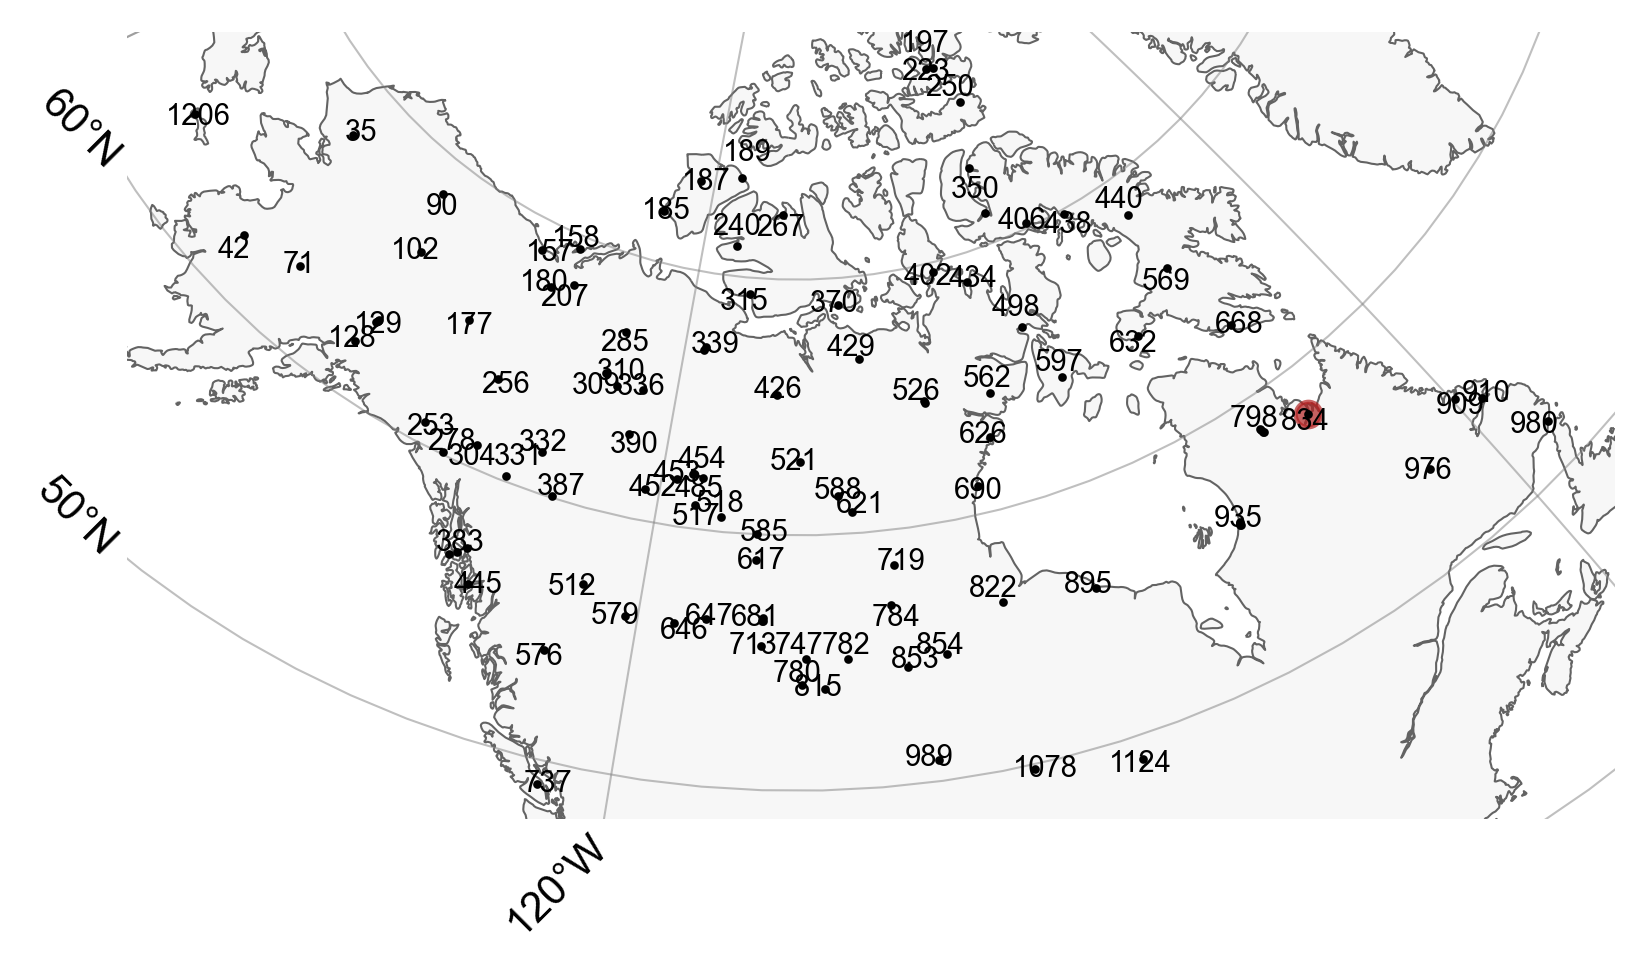

In [3]:
# initialize the graph
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

# set up projection with better scaling near the poles 
projection = ccrs.AzimuthalEquidistant(central_longitude=-108.842926, central_latitude=66.037547)

# draw the underlying graph
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(latlong=True)
v.draw_samples()
v.draw_obs_nodes(use_ids=True)
# adding a red * at the sample we're trying to predict
v.ax.scatter(coord[sp_graph.nodes[834]['sample_idx'],0], coord[sp_graph.nodes[834]['sample_idx'],1], 
             color='firebrick', marker='o', alpha=0.7, s=5*v.obs_node_size,
             transform=ccrs.AzimuthalEquidistant(coord[sp_graph.nodes[834]['sample_idx'],0][0], coord[sp_graph.nodes[834]['sample_idx'],1][0]))

In the graph above, I will assume I do not know the coordinates for the sample assigned to deme _834_. To do this in code, I will first set the coordinates associated with this sample to some random, _unassigned_ portion of the habitat (e.g., middle of the Hudson Bay). As a user, you will need to do the same for your sample. 

_Note_: Since `FEEMS` requires locations for each of its samples, this is a necessary step.

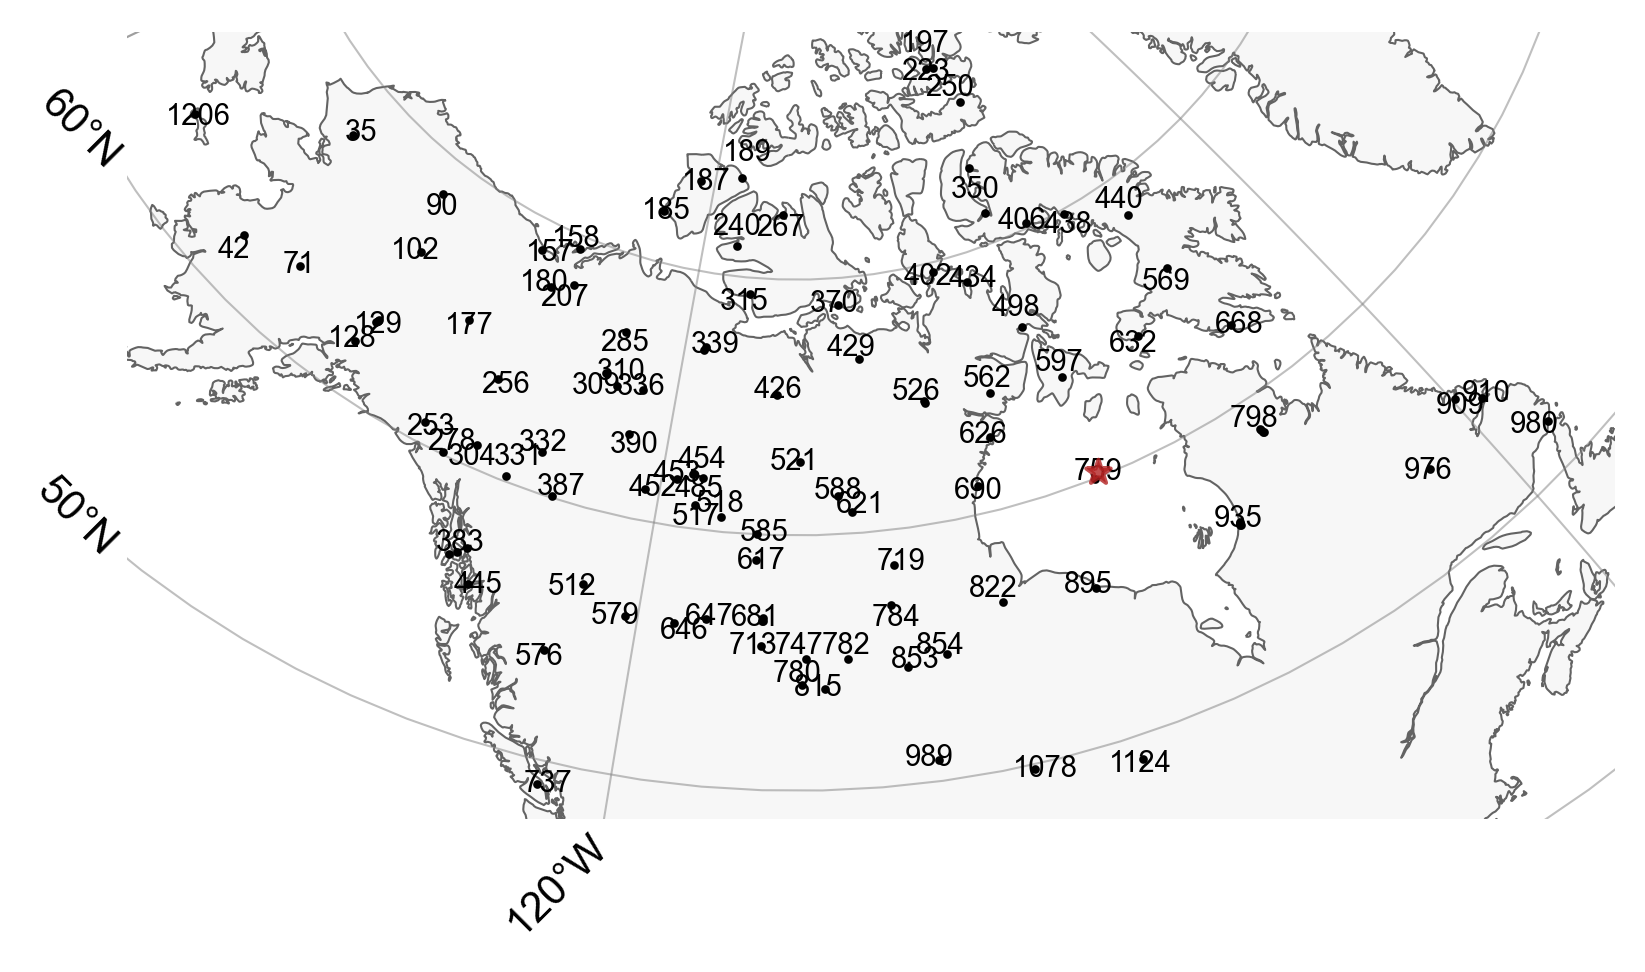

In [33]:
# changing the coordinate associated with this sample
coord_new = copy(coord)
coord_new[sp_graph.nodes[834]['sample_idx'],:] = [-85, 60]

# re-creating the graph
sp_graph = SpatialGraph(genotypes, coord_new, grid, edges, scale_snps=True)

# visualizing the new graph with the relocated sample
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(latlong=True)
v.draw_samples()
v.draw_obs_nodes(use_ids=True)
# see the presence of a new sampled deme: 759
v.ax.scatter(v.grid[759,0], v.grid[759,1], 
             color='firebrick', marker='*', alpha=0.8, s=5*v.obs_node_size, zorder=2)

Since, we know where we spoofed the location of the sample to be, we know which deme ID (i.e., _759_) contains the putative "long-range" gene flow event. 

So, we will fit `FEEMSmix` to this deme and observe the results. 

In [ ]:
# sp_graph.fit(lamb=2., lamb_q=1., optimize_q='n-dim')

df759 = sp_graph.calc_contour(destid=759)

In [ ]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=10, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(latlong=True)
v.draw_samples()
v.draw_obs_nodes(use_ids=False)
# drawing a red circle around the true location
v.ax.scatter(coord[sp_graph.nodes[759]['sample_idx'],0], coord[sp_graph.nodes[759]['sample_idx'],1], 
             color='firebrick', marker='o', alpha=0.7, s=5*v.obs_node_size,
             transform=ccrs.AzimuthalEquidistant(coord[sp_graph.nodes[759]['sample_idx'],0][0], coord[sp_graph.nodes[759]['sample_idx'],1][0]))
# drawing a log-lik contour for the location of this sample
v.draw_loglik_contour(df759, levels=-3, draw_arrow=False)

We see that the predicted location from `FEEMSmix` is not too far from the true location for this sample ($\sim 800 \text{km}$), especially, when seen on a continental scale. This is a hard problem: in fact, we know that wolves tend to be highly mobile and that the Eastern region of Canada is a region of relatively high migration in this species. 

## Analysis of model fits with PCA and `admixture` (Alexander _et al_ 2009)

With both analyses, we will follow 4 steps to obtaining our final fits:

1. obtaining expected pairwise distances with each model (this will come from reconstructing the expected genotypes under each model)
2. fitting a linear model to the observed genetic distances & extracting outliers from this fit based on FDR correction (choose `alpha` here)
3. plotting the resulting fit with $R^2$ values
4. highlighting samples on the map that are not well fit under this model (i.e., have lower expected distance or higher genetic similarity than observed in the genotype data)

### I. PCA analysis

In [239]:
# 1.
# leaving numPC as None means we use all n_samples-1
pcdist, gendist = pairwise_PCA_distances(sp_graph.genotypes, numPC=None)

# performing OLS on the two distances
mod = sm.OLS(gendist, sm.add_constant(pcdist))
res = mod.fit()
muhat, betahat = res.params

### Picking outliers

Below, we will use the same linear model as in `FEEMSmix` for picking outlier demes given an expected fit (here, PCA) to the observed genetic distances. 

In [240]:
# 2.
pvals = norm.cdf(res.resid, np.mean(res.resid), np.std(res.resid))

# choosing an appropriate FWER
pass_idx, _ = fdrcorrection(pvals, alpha=0.3)

Text(0, 0.5, 'empirical distance')

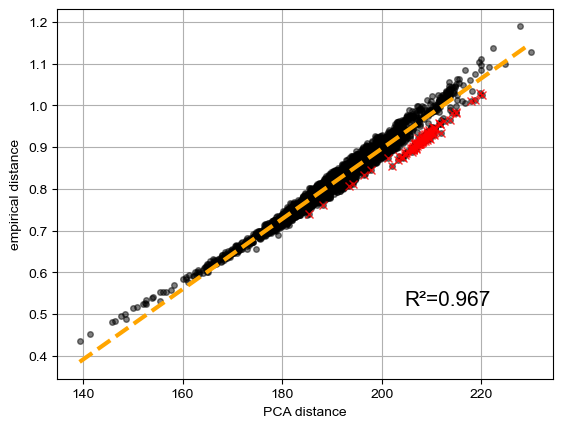

In [241]:
# 3. 
# plotting the results
plt.plot(pcdist, gendist, 'o', color='k', alpha=0.5, markersize=4)
x_ = np.linspace(np.min(pcdist), np.max(pcdist), 12)
plt.plot(x_, muhat + betahat*x_, color='orange', ls='--', lw=3)
plt.text(0.7, 0.2, "R²={:.3f}".format(res.rsquared), fontsize=15, transform=plt.gca().transAxes); plt.grid(); 
plt.plot(pcdist[pass_idx], gendist[pass_idx], 'rx', alpha=0.8)
plt.xlabel('PCA distance'); plt.ylabel('empirical distance')

In [242]:
# get the ID of the demes implicated as outliers
idx, idy = [], []
for k in np.where(pass_idx)[0]:
    idx.append(np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1) 
    idy.append(int(k - 0.5*idx[-1]*(idx[-1]-1)))

### What is the location of these outlier samples on the map?

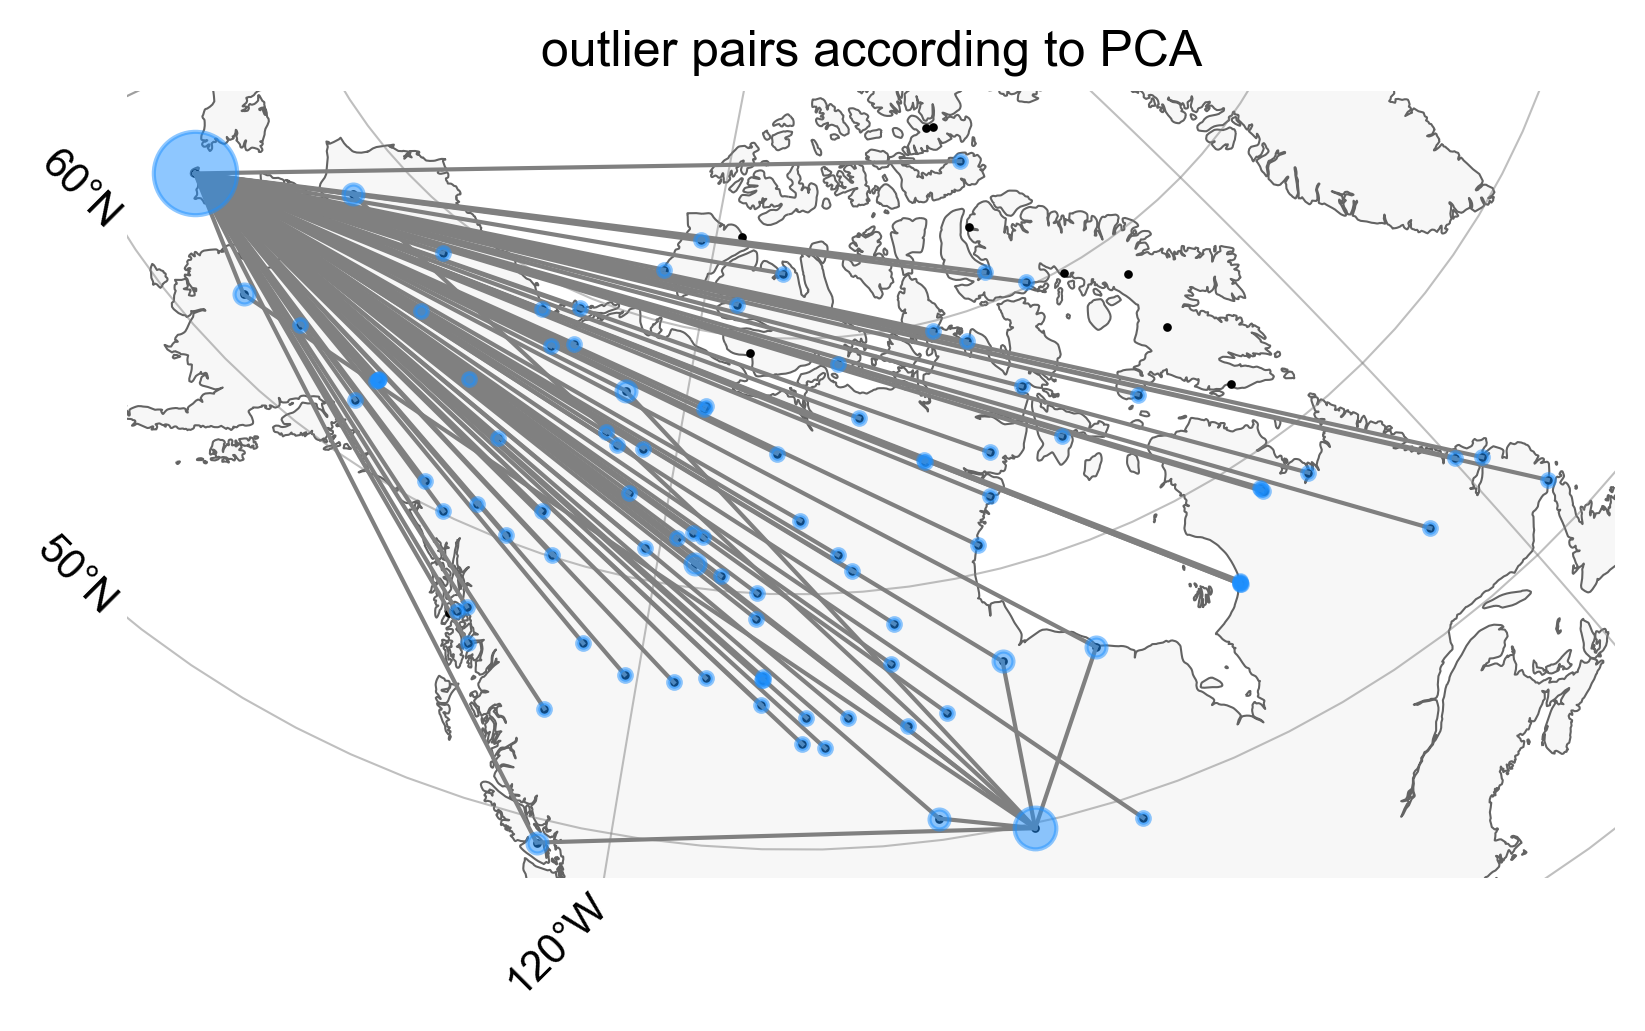

In [243]:
# 4.
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(latlong=True)
v.draw_samples()
v.ax.set_title('outlier pairs according to PCA')
# projecting coordinates to CRS used by FEEMS
projx = project_coords(coord[idx], v.proj); projy = project_coords(coord[idy], v.proj)
for i in range(len(idx)):
    v.ax.plot([projx[i][0], projy[i][0]], 
              [projx[i][1], projy[i][1]] ,
              color='grey', linewidth=2*v.edge_width)
# circling the demes based on how many times it has been implicated
b, c = np.unique([idx, idy], return_counts=True)
projb = project_coords(coord[b], v.proj)
for i in range(len(b)):
    v.ax.plot(projb[i,0], projb[i,1], 'o', color='dodgerblue', 
              markersize=v.sample_pt_size*np.log10(c[i]+1), alpha=0.5)

From this analysis we see that most of the outlier pairs are with the sample that was sampled all the way in western Alaska, indicating that the geographic location of the sample does not match its location in genetic space. 

Try rerunning the analysis with `numPC=2` to see how the outliers fall out. 

### II. `admixture` analysis

We provide .P and .Q files for $K=7$ and $K=8$ as part of the repo for demonstration purposes. You can pass in your own files for more exploratory analyses. 

In [232]:
# 1.
# leaving numPC as None means we use all n_samples-1
admixdist, _ = pairwise_admixture_distances("{}/wolvesadmix.7.P".format(data_path),
                                            "{}/wolvesadmix.7.Q".format(data_path),
                                            sp_graph.genotypes)

# performing OLS on the two distances
mod = sm.OLS(gendist, sm.add_constant(admixdist))
res = mod.fit()
muhat, betahat = res.params

Reading in .P file...
Number of loci: 17729, K: 7
Reading in .Q file...
Number of individuals: 111


In [233]:
# 2.
pvals = norm.cdf(res.resid, np.mean(res.resid), np.std(res.resid))

# choosing an appropriate FWER
pass_idx, _ = fdrcorrection(pvals, alpha=0.3)

Text(0, 0.5, 'empirical distance')

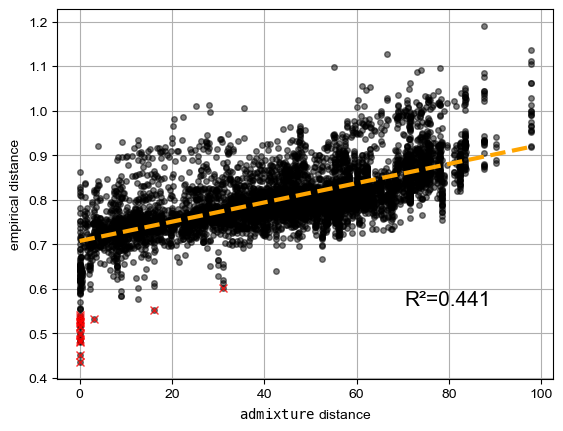

In [235]:
# 3.
# plotting the results
plt.plot(admixdist, gendist, 'o', color='k', alpha=0.5, markersize=4)
x_ = np.linspace(np.min(admixdist), np.max(admixdist), 12)
plt.plot(x_, muhat + betahat*x_, color='orange', ls='--', lw=3)
plt.text(0.7, 0.2, "R²={:.3f}".format(res.rsquared), fontsize=15, transform=plt.gca().transAxes); plt.grid(); 
plt.plot(admixdist[pass_idx], gendist[pass_idx], 'rx', alpha=0.8)
plt.xlabel(r'$\tt{admixture}$ distance'); plt.ylabel('empirical distance')

In [236]:
# get the ID of the demes implicated as outliers
idx, idy = [], []
for k in np.where(pass_idx)[0]:
    idx.append(np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1) 
    idy.append(int(k - 0.5*idx[-1]*(idx[-1]-1)))

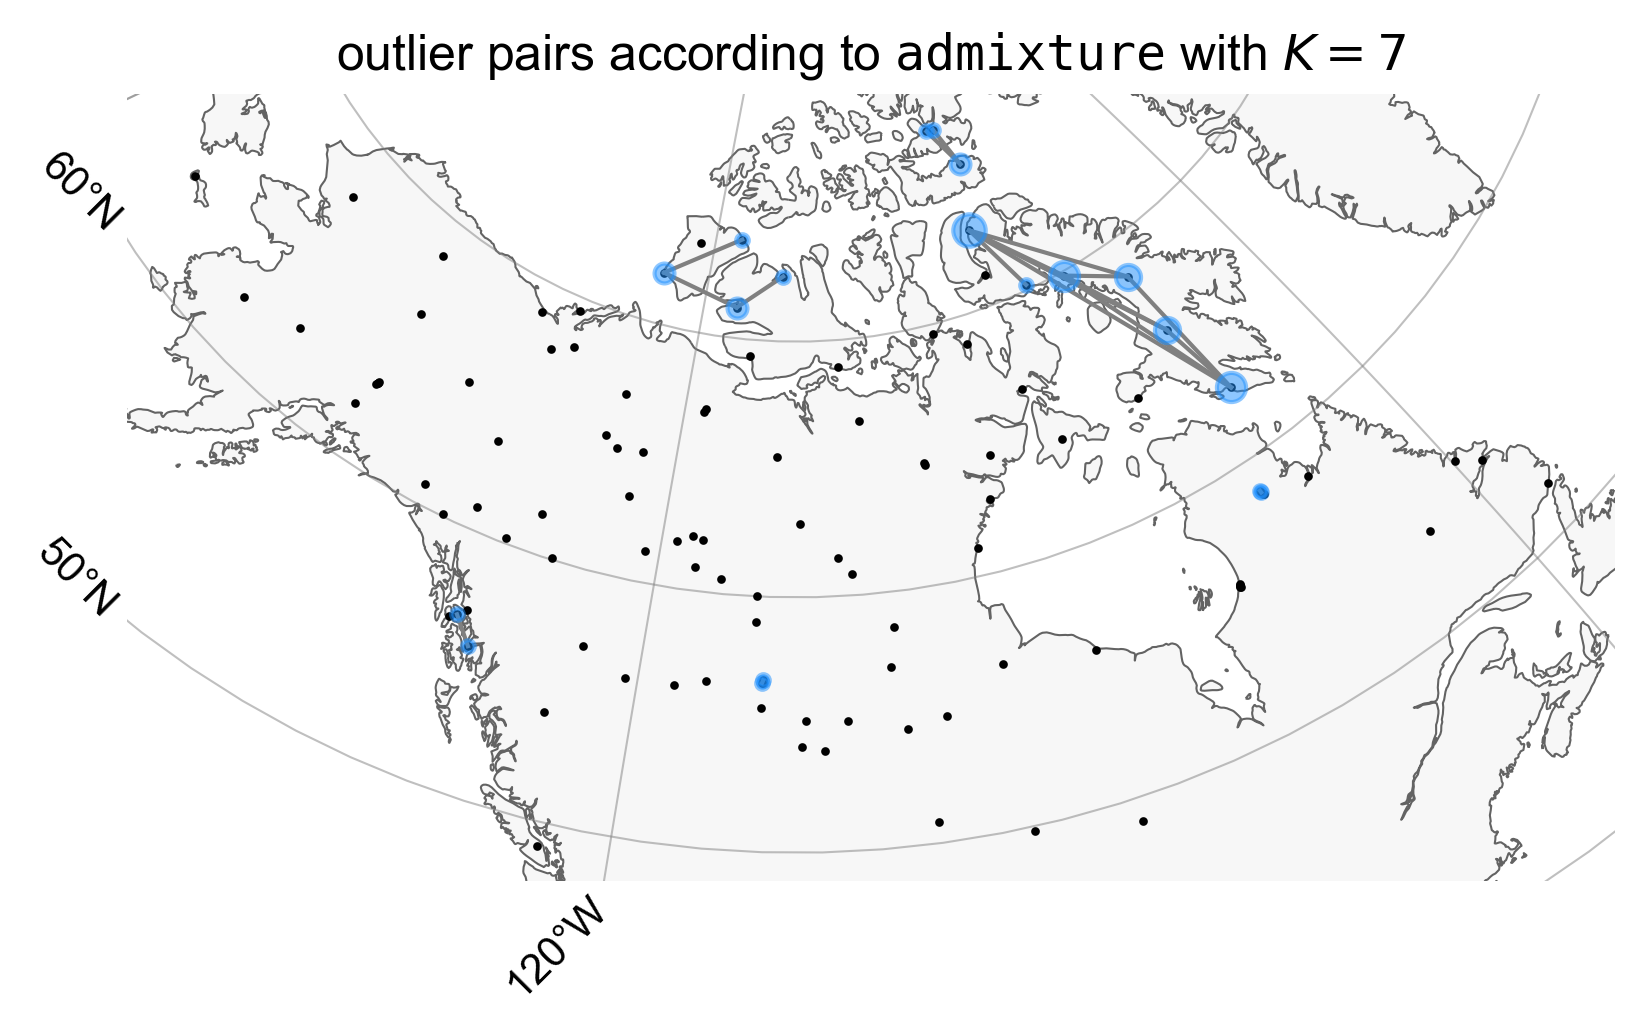

In [238]:
# 4.
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map(latlong=True)
v.draw_samples()
v.ax.set_title(r'outlier pairs according to $\tt{admixture}$ with $K=7$')
# projecting coordinates to CRS used by FEEMS
projx = project_coords(coord[idx], v.proj); projy = project_coords(coord[idy], v.proj)
# drawing lines between outlier demes
for i in range(len(idx)):
    v.ax.plot([projx[i][0], projy[i][0]], 
              [projx[i][1], projy[i][1]] ,
              color='grey', linewidth=2*v.edge_width)
# circling the demes based on how many times it has been implicated
b, c = np.unique([idx, idy], return_counts=True)
projb = project_coords(coord[b], v.proj)
for i in range(len(b)):
    v.ax.plot(projb[i,0], projb[i,1], 'o', color='dodgerblue', 
              markersize=v.sample_pt_size*np.log10(c[i]+1), alpha=0.5)